#**1. Import Monitored Data and Make DatrFrame(df_mon)**

In [2]:
import pickle
from google.colab import drive
drive.mount('/content/gdrive')

USE_SUBLABEL = False
URL_PER_SITE = 10
TOTAL_URLS   = 950

# Load the pickle file
print("Loading datafile...")
# '/content/gdrive/My Drive/Colab Notebooks/pi_digits.txt'
with open('/content/gdrive/My Drive/Colab Notebooks/mon_standard.pkl', 'rb') as fi: # Path to mon_standard.pkl in Colab
    data = pickle.load(fi)

X1 = [] # Array to store instances (timestamps) - 19,000 instances, e.g., [[0.0, 0.5, 3.4, ...], [0.0, 4.5, ...], [0.0, 1.5, ...], ... [... ,45.8]]
X2 = [] # Array to store instances (direction*size) - size information
y = [] # Array to store the site of each instance - 19,000 instances, e.g., [0, 0, 0, 0, 0, 0, ..., 94, 94, 94, 94, 94]

# Differentiate instances and sites, and store them in the respective x and y arrays
# x array (direction*timestamp), y array (site label)
for i in range(TOTAL_URLS):
    if USE_SUBLABEL:
        label = i
    else:
        label = i // URL_PER_SITE # Calculate which site's URL the current URL being processed belongs to and set that value as the label. Thus, URLs fetched from the same site are labeled identically.
    for sample in data[i]:
        size_seq = []
        time_seq = []
        for c in sample:
            dr = 1 if c > 0 else -1
            time_seq.append(abs(c))
            size_seq.append(dr * 512)
        X1.append(time_seq)
        X2.append(size_seq)
        y.append(label)
size = len(y)

print(f'Total samples: {size}') # Output: 19000


Mounted at /content/gdrive
Loading datafile...
Total samples: 19000


feature를 배열 형태로 추출

In [3]:
n_pack = [] #Array to store total number of packets
n_in = [] #Array to store number of incoming packets : server -> client (size < 0)
n_out = [] #Array to store number of outgoing packets : client -> server (size > 0)
r_in = [] #Array to store ratio of incoming packets
r_out = [] #Array to store ratio of outcoming packets
in_first = [] #Array to store number of incoming packet in First 30 Packets
out_first = [] #Array to store number of outcoming packet in First 30 Packets
transmission_time = [] #Array to store total transmission time
packets_per_sec = [] #Array to store #of packets per second

for i in range (0,len(X2)):
  count = 0
  count_30 = 0
  for j in range (0,len(X2[i])):
    if X2[i][j] < 0:
      count+=1
      if j < 30: #incoming packet이고 처음 30개 안에 해당된다면
        count_30+=1
  n_pack.append(len(X2[i]))
  n_in.append(count)
  n_out.append(len(X2[i])-count)
  r_in.append(count/len(X2[i]))
  r_out.append(1-count/len(X2[i]))
  in_first.append(count_30)
  out_first.append(30-count_30)
  transmission_time.append(X1[i][-1])
  packets_per_sec.append(len(X2[i])/X1[i][-1])

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

####### 새로 df_mon 이라는 dataframe을 만들었습니다
df_mon = pd.DataFrame({"total packets": n_pack, "#of incoming packets": n_in, "#of outgoing packets": n_out,
                       "ratio of incoming packets": r_in, "ratio of outgoing packets": r_out,
                       "#of incoming(first30)": in_first, "#of outgoing(first30)": out_first, "total time": transmission_time, "#of packets per sec": packets_per_sec, "label": y})


In [5]:
df_mon.head()

,total packets,#of incoming packets,#of outgoing packets,ratio of incoming packets,ratio of outgoing packets,#of incoming(first30),#of outgoing(first30),total time,#of packets per sec,label
0,1421,1300,121,0.914849,0.085151,21,9,10.14,140.138067,0
1,518,438,80,0.845560,0.154440,22,8,10.16,50.984252,0
2,1358,1240,118,0.913108,0.086892,23,7,11.11,122.232223,0
3,1446,1324,122,0.915629,0.084371,21,9,13.36,108.233533,0
4,1406,1291,115,0.918208,0.081792,22,8,10.64,132.142857,0


In [6]:
df_mon.tail()

,total packets,#of incoming packets,#of outgoing packets,ratio of incoming packets,ratio of outgoing packets,#of incoming(first30),#of outgoing(first30),total time,#of packets per sec,label
18995,9434,8815,619,0.934386,0.065614,23,7,43.91,214.848554,94
18996,9956,9404,552,0.944556,0.055444,23,7,15.60,638.205128,94
18997,9952,9373,579,0.941821,0.058179,22,8,14.93,666.577361,94
18998,9926,9236,690,0.930486,0.069514,23,7,19.91,498.543446,94
18999,9925,9168,757,0.923728,0.076272,23,7,13.76,721.293605,94


# **2. Random Forest**

## **2-1. Train/Test split**

In [7]:
from sklearn.model_selection import train_test_split

#   column number
#   0: total packets,	1: #of incoming packets, 2:	#of outgoing packets
#   3: ratio of incoming packets, 4: ratio of outgoing packets
#   5: #of incoming(first30), 6: #of outgoing(first30), 7: total time, 8: #of packets per sec

# 이 부분을 고쳐서 model train에 사용할 feature를 고르고 accuracy를 확인 가능

'''
## Case 1: All the features - accuracy score:  0.6428947368421053    <----- best
## Case 2: Top 5 feautures - accuracy score:  0.48947368421052634
## Case 3: Top 5 features + no.5 + no.6 - accuracy score:  0.5839473684210527
## Case 4: Top 5 features + no.7 + no.8 - accuracy score:  0.5676315789473684
'''
test1 = [0,1,2,3,4,5,6,7,8]
test2 = [0,1,2,3,4]
test3 = [0,1,2,3,4,5,6]
test4 = [0,1,2,3,4,7,8]
X = df_mon.iloc[:, test1]
y = df_mon['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

## **2-2. model training and testing (print accuracy score and classification report)**

In [8]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import classification_report

In [9]:
#Grid Search - 너무 느림 , best parameter는 {entropy, 100}
'''
from sklearn.model_selection import GridSearchCV

# Decision Tree Classifier 객체 생성
rf_classifier = RandomForestClassifier()

# 탐색할 매개 변수 그리드 설정
param_grid = {
    'criterion': ['entropy', 'gini'],
    'n_estimators': [20, 100]
}

# GridSearchCV를 사용하여 최적의 매개 변수 탐색
grid_search = GridSearchCV(rf_classifier, param_grid, cv=5, n_jobs=-1, verbose=3)
grid_search.fit(X_train, y_train)

# 최적의 매개 변수 출력
print("최적 매개 변수:", grid_search.best_params_)

# 최적의 매개 변수를 사용한 모델
best_dt_model = grid_search.best_estimator_

# 테스트 세트로 모델 평가
accuracy = best_dt_model.score(X_test, y_test)
print("테스트 세트 정확도:", accuracy)
'''

'\nfrom sklearn.model_selection import GridSearchCV\n\n# Decision Tree Classifier 객체 생성\nrf_classifier = RandomForestClassifier()\n\n# 탐색할 매개 변수 그리드 설정\nparam_grid = {\n    \'criterion\': [\'entropy\', \'gini\'],\n    \'n_estimators\': [20, 100]\n}\n\n# GridSearchCV를 사용하여 최적의 매개 변수 탐색\ngrid_search = GridSearchCV(rf_classifier, param_grid, cv=5, n_jobs=-1, verbose=3)\ngrid_search.fit(X_train, y_train)\n\n# 최적의 매개 변수 출력\nprint("최적 매개 변수:", grid_search.best_params_)\n\n# 최적의 매개 변수를 사용한 모델\nbest_dt_model = grid_search.best_estimator_\n\n# 테스트 세트로 모델 평가\naccuracy = best_dt_model.score(X_test, y_test)\nprint("테스트 세트 정확도:", accuracy)\n'

In [10]:
X = df_mon[df_mon.columns[:-1]] #모든 feature를 사용해서 분류하는 것이 성능이 제일 좋았다
y = df_mon['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

clf = RandomForestClassifier(n_estimators=100, criterion="entropy", max_depth=10, min_samples_split=2, max_features="sqrt", random_state=0)
clf.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', max_depth=10, random_state=0)

In [11]:
y_pred = clf.predict(X_test) #Test the trained model using test data

print("Accuracy on test dataset: {}".format(accuracy_score(y_test, y_pred)))
precision = precision_score(y_test, y_pred, average='micro')
print("Precision on test dataset: {}".format(precision))
print(classification_report(y_test, y_pred, labels=list(range(95))))

Accuracy on test dataset: 0.6428947368421053
Precision on test dataset: 0.6428947368421053
              precision    recall  f1-score   support

           0       0.75      0.55      0.64        38
           1       0.51      0.50      0.51        42
           2       0.71      0.85      0.78        41
           3       0.58      0.72      0.64        40
           4       0.57      0.67      0.62        30
           5       0.61      0.66      0.63        35
           6       0.39      0.82      0.52        33
           7       0.64      0.74      0.69        43
           8       0.72      0.78      0.75        36
           9       0.67      0.60      0.63        52
          10       0.88      0.52      0.66        44
          11       0.50      0.65      0.57        40
          12       0.78      0.90      0.83        39
          13       0.83      0.24      0.38        41
          14       0.79      0.58      0.67        33
          15       0.67      0.75      0.71 

In [12]:
body = classification_report(y_test, y_pred, output_dict = True)
report_df = pd.DataFrame(body).T
f1_each_class = report_df['f1-score'][:-3] # 맨 뒤 3개는 각각 총 accuracy, macro avg, weighted avg를 저장하므로 제
f1_class = f1_each_class.tolist()
print(f1_class)

[0.6363636363636364, 0.5060240963855421, 0.7777777777777778, 0.6444444444444445, 0.6153846153846153, 0.6301369863013698, 0.5242718446601942, 0.6881720430107526, 0.7466666666666666, 0.6326530612244897, 0.6571428571428571, 0.5652173913043479, 0.8333333333333333, 0.37735849056603776, 0.6666666666666667, 0.7058823529411765, 0.7000000000000001, 0.5555555555555556, 0.6666666666666667, 0.736842105263158, 0.8941176470588235, 0.45333333333333337, 0.6571428571428571, 0.6823529411764706, 0.20338983050847456, 0.6, 0.7291666666666666, 0.44155844155844154, 0.6666666666666666, 0.6538461538461539, 0.732394366197183, 0.7272727272727273, 0.48484848484848486, 0.5316455696202531, 0.2448979591836735, 0.6105263157894737, 0.8043478260869564, 0.5384615384615384, 0.6593406593406593, 0.6521739130434783, 0.6493506493506495, 0.7155963302752292, 0.4807692307692307, 0.7012987012987013, 0.9032258064516129, 0.5365853658536585, 0.5714285714285714, 0.5000000000000001, 0.6944444444444444, 0.823529411764706, 0.6813186813

## **2-3. Testset 분류 결과 및 plot을 이용한 시각화 (accuracy graph, and precision-recall curve for each class)**

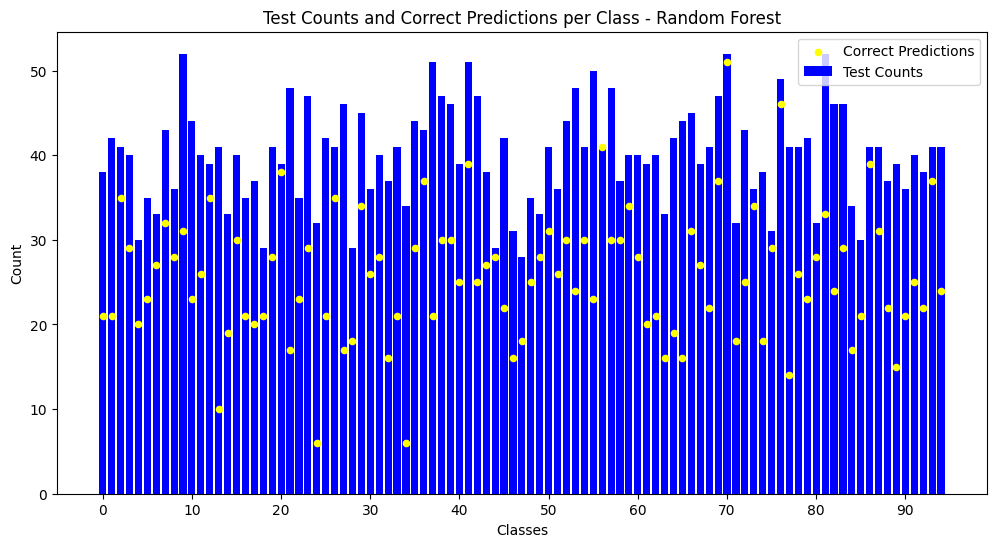

In [13]:
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter

# 각 클래스별 테스트 데이터 개수 계산
test_counts = Counter(y_test)

# 각 클래스별로 예측이 맞은 데이터 개수 계산
correct_predictions = (y_test == y_pred)
correct_counts = Counter(y_test[correct_predictions])

# 클래스 범위
num_classes = 95
classes = np.arange(num_classes)

# 각 클래스별 테스트 데이터 개수를 막대 그래프로 표시
plt.figure(figsize=(12, 6))  # 그래프 크기 조절
plt.bar(classes, [test_counts[i] for i in classes], color='blue', label='Test Counts')

# 예측이 맞은 데이터 개수를 점으로 표시
plt.scatter(classes, [correct_counts[i] if i in correct_counts else 0 for i in classes], color='yellow', label='Correct Predictions', s=20)
plt.xticks(np.arange(0, num_classes, 10))

plt.xlabel('Classes')
plt.ylabel('Count')
plt.title('Test Counts and Correct Predictions per Class - Random Forest')
plt.legend()
plt.show()

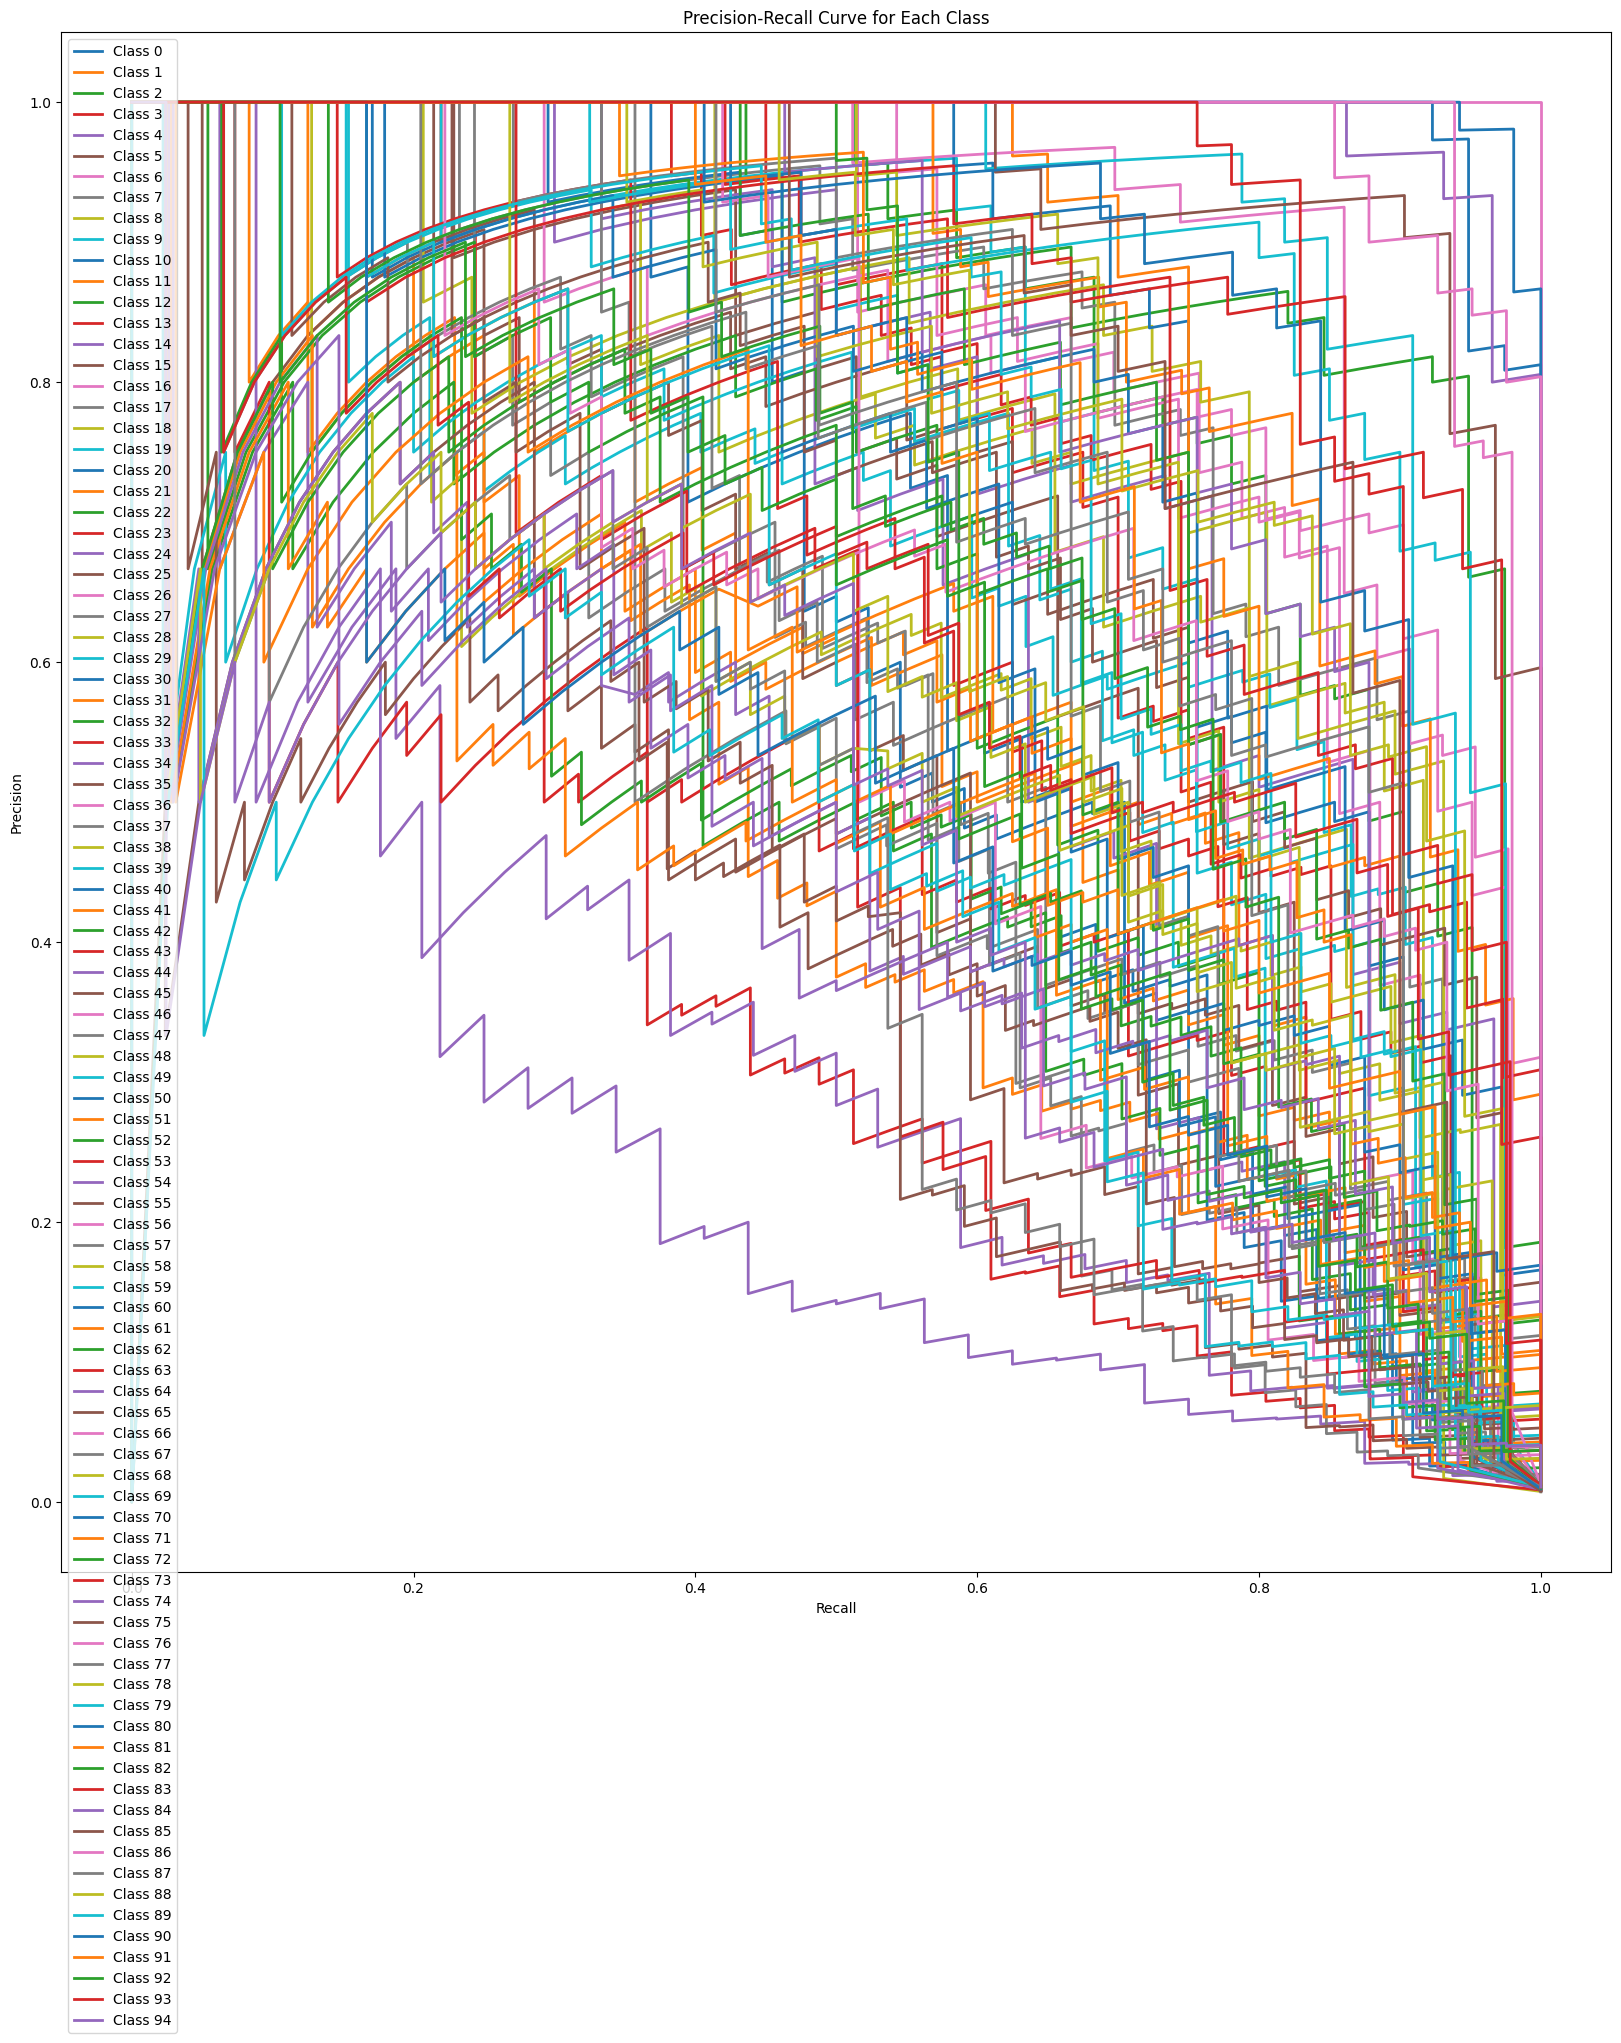

In [14]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.multiclass import OneVsOneClassifier
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

y_probs = clf.predict_proba(X_test)

# Precision-Recall curve 계산
precision = dict()
recall = dict()
plt.figure(figsize=(20, 20))

for i in range(len(set(y_test))):  # 각 클래스마다 Precision과 Recall을 계산
    precision[i], recall[i], _ = precision_recall_curve((y_test == i).astype(int), y_probs[:, i])
    plt.plot(recall[i], precision[i], lw=2, label=f'Class {i}')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.title('Precision-Recall Curve for Each Class')
plt.show()


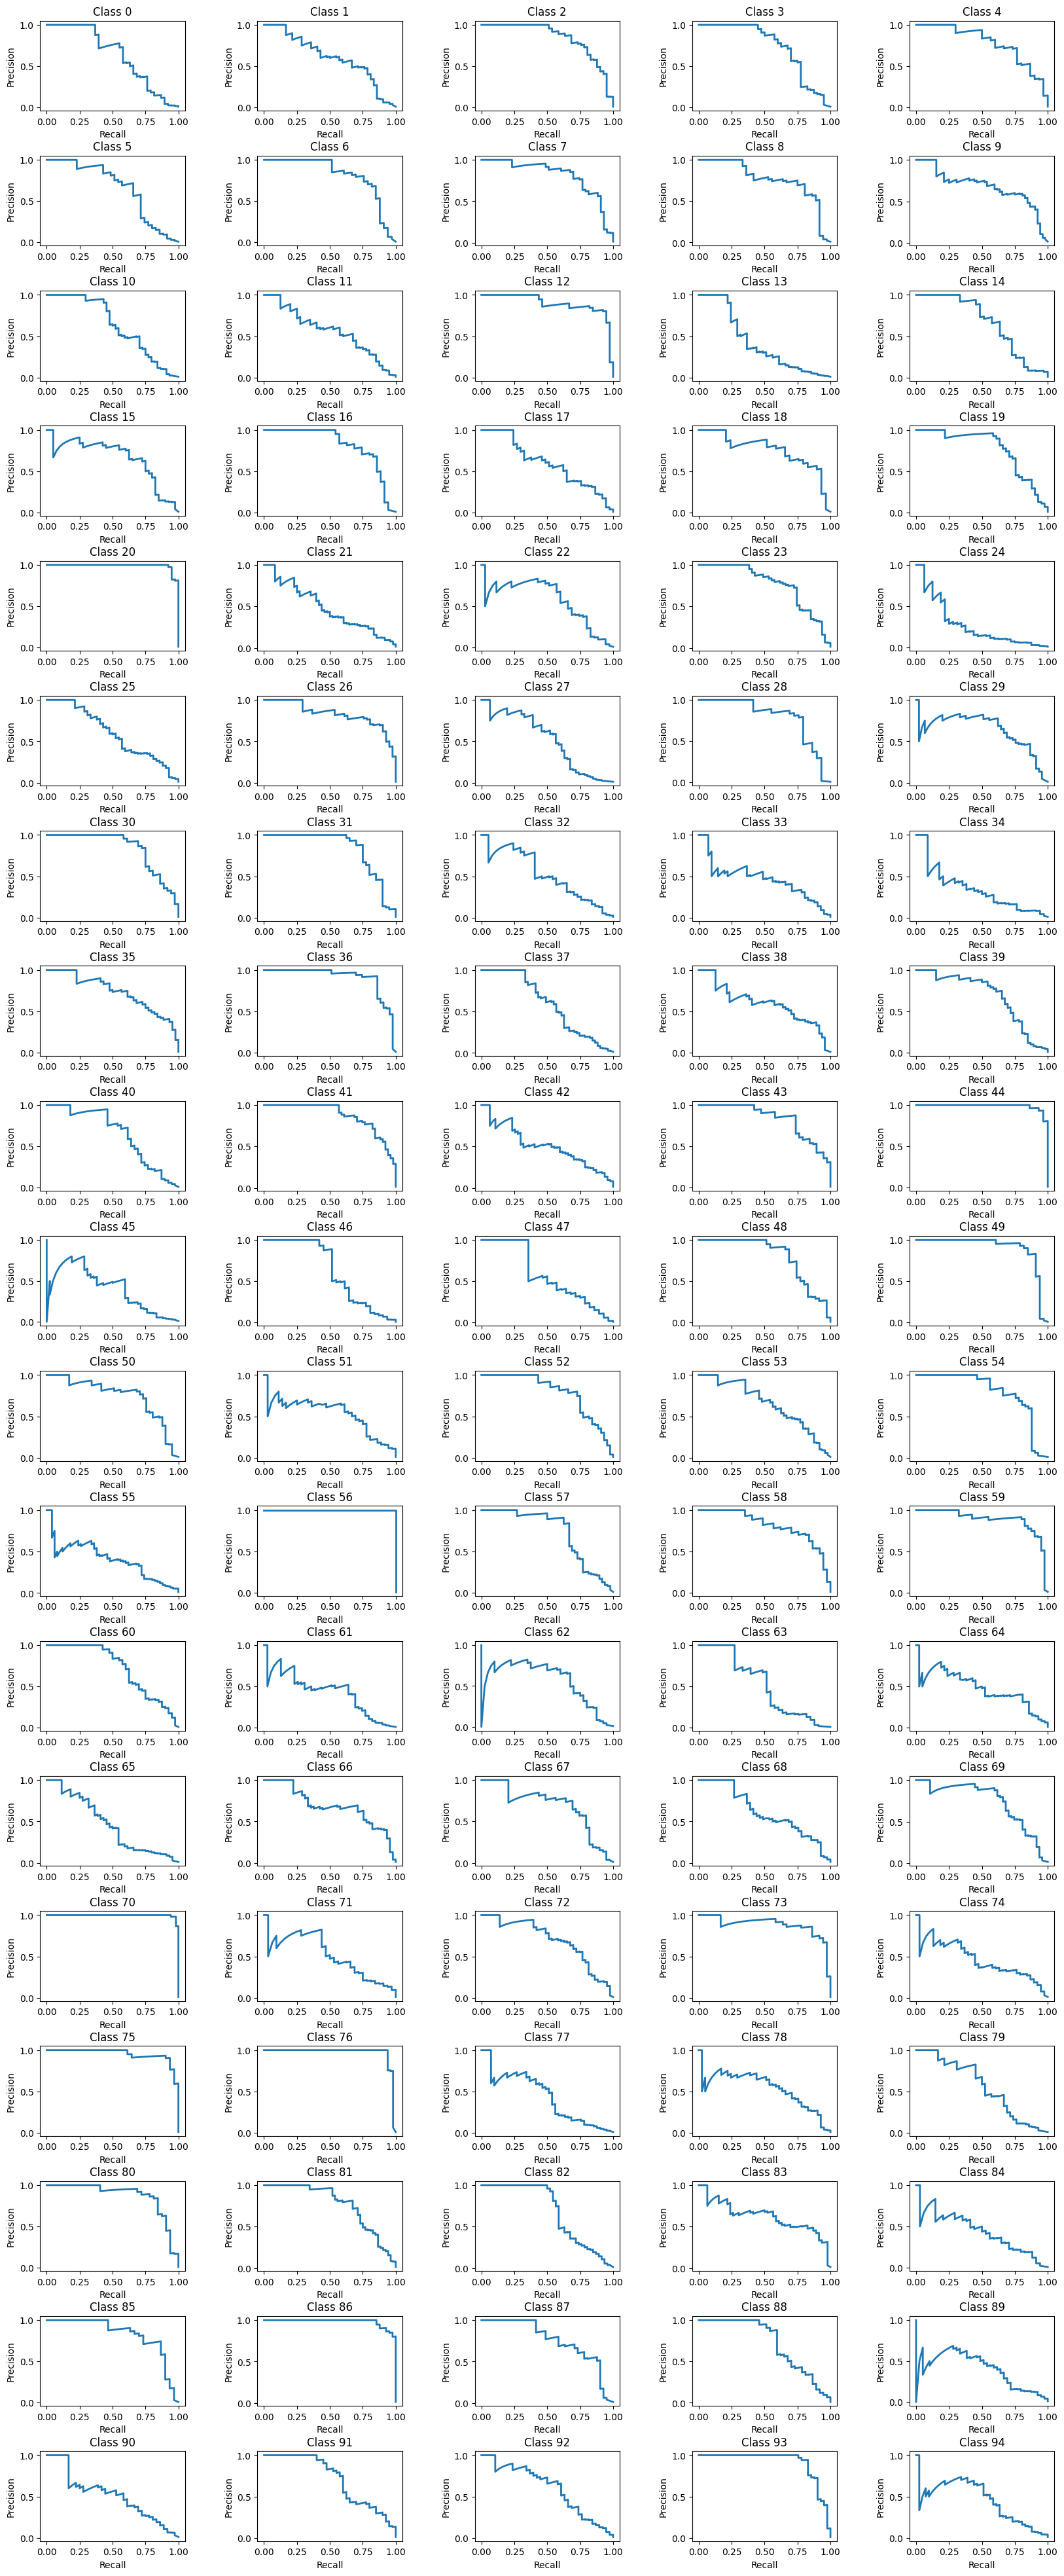

In [15]:
# 바로 위의 class 별 Precision-Recall curve 를 보기 쉽게 나타내기
precision = dict()
recall = dict()

fig, axes = plt.subplots(nrows=19, ncols=5, figsize=(20, 50))
plt.subplots_adjust(wspace=0.5, hspace=0.5)  # subplot 간격 조정

for i in range(19):  # 행 반복
    for j in range(5):  # 열 반복
        idx = i * 5 + j
        if idx >= len(set(y_test)):  # 클래스 개수보다 많으면 종료
            break

        precision[idx], recall[idx], _ = precision_recall_curve((y_test == idx).astype(int), y_probs[:, idx])
        axes[i, j].plot(recall[idx], precision[idx], lw=2)
        axes[i, j].set_xlabel('Recall')
        axes[i, j].set_ylabel('Precision')
        axes[i, j].set_title(f'Class {idx}')

plt.show()


# **3. Random Forest - More Detailed Classification Results**


#### **(1) True Class, Predicted Class, 예측 성공 여부, 'True Class'에 부여된 확률, 'True Class'의 가능성 순위 출력 및 배열에 저장**
```
< 출력 예시 >
Test Data 3785 - True Class: 43, Predicted Class: 43
★ Correct Prediction
Predicted Class 43: 0.4240951980606782
Predicted Class 20: 0.1034466449002824
Predicted Class 57: 0.0902982938114517
Predicted Class 83: 0.05367724599961443
Predicted Class 0: 0.046705812161694504
▷ Predicted Probability for True Class (43): 0.4240951980606782
▷ Rank of True Class Probability: 1

```

In [17]:
probabilities = clf.predict_proba(X_test)
sorted_indexes = np.argsort(probabilities, axis=1)

true_class_prob_array = [] # 모델이 계산한 실제 클래스의 확률
true_class_rank_array = [] # 실제 클래스의 예측된 확률 순위 (크기순)
for i, (sorted_index, true_class, pred_class) in enumerate(zip(sorted_indexes, y_test, y_pred)):
    print(f"Test Data {i + 1} - True Class: {true_class}, Predicted Class: {pred_class}")
    if true_class == pred_class:
      print("★ Correct Prediction") # 올바르게 분류한 경우만 출력
    for index in sorted_index[::-1][:5]: # 확률 상위 5개 class만 출력
        print(f"Predicted Class {index}: {probabilities[i][index]}")
    true_class_prob = probabilities[i][true_class]  # 실제 클래스에 대한 예측된 확률
    true_class_prob_array.append(true_class_prob)  # 배열에 추가
    true_class_rank = np.where(sorted_index[::-1] == true_class)[0][0] + 1  # 실제 클래스의 순위
    true_class_rank_array.append(true_class_rank)  # 배열에 추가
    print(f"▷ Predicted Probability for True Class ({true_class}): {true_class_prob}")
    print(f"▷ Rank of True Class Probability: {true_class_rank}")
    print()


스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
★ Correct Prediction
Predicted Class 89: 0.47642114484798315
Predicted Class 32: 0.2683531153007065
Predicted Class 16: 0.11257191442942684
Predicted Class 65: 0.040158985870274916
Predicted Class 13: 0.026128471245659503
▷ Predicted Probability for True Class (89): 0.47642114484798315
▷ Rank of True Class Probability: 1

Test Data 3284 - True Class: 6, Predicted Class: 6
★ Correct Prediction
Predicted Class 6: 0.520918800187494
Predicted Class 41: 0.1175538308518715
Predicted Class 4: 0.08244523860548447
Predicted Class 2: 0.048131878410880756
Predicted Class 52: 0.03856969611482723
▷ Predicted Probability for True Class (6): 0.520918800187494
▷ Rank of True Class Probability: 1

Test Data 3285 - True Class: 18, Predicted Class: 18
★ Correct Prediction
Predicted Class 18: 0.8132922343636737
Predicted Class 4: 0.09958580170268012
Predicted Class 81: 0.04620631329829827
Predicted Class 1: 0.009524982218352327
Predicted Class 23: 0.007650171015968072
▷

#### **(2) unmonitored 분류 를 위한 작업...**
#### *가능성 1위 라벨의 확률, 가능성 2위 라벨의 확률을 correct/wrong case로 나눠 배열에 저장, 예측 class에 대한 model f1 score와 임의로 정한 confidence level을 출력, plot을 그려 분포를 확인*
```
<출력 예시>
Test Data 3796 - True Class: 2, Predicted Class 2
Predicted Class 2: 0.43794354906758615
Predicted Class 1: 0.18068403212365738
Predicted Class 37: 0.12900891189862027
Predicted Class 40: 0.10314236058091078
Predicted Class 21: 0.025782664555201788
★ Correct Prediction!
■ Confidence:  0.34062276038590034
```



In [18]:
first_proba_c =[] # 1위 확률 (예측 성공 케이스)
second_proba_c =[] # 2위 확률 (예측 성공 케이스)
first_proba_w =[] # 1위 확률 (예측 실패 케이스)
second_proba_w =[] # 2위 확률 (예측 실패 케이스)
proba_gap_c = [] # 예측 성공시 (1위 확률 - 2위 확률)을 저장
proba_gap_w = [] # 예측 실패시 (1위 확률 - 2위 확률)을 저장
proba_ratio_c = [] # 예측 성공시 (1위 확률 / 2위 확률)을 저장
proba_ratio_w =[] # 예측 실패시 (1위 확률 / 2위 확률)을 저장
confidence_c = []
confidence_w = []
confidence_all = []

# correct, wrong 관계없이
proba_top = [] # 1위 확률들만 저장
proba_gap = [] # 1위 확률 - 2위 확률 저장
proba_ratio = [] # 1위 확률 / 2위 확률 저장
tf_label = [] # correct / wrong 여부 저장 correct = 1, wrong = 0 저장
# 따라서 위 4개 배열에는 모든 test case (3800개)의 해당값을 저장

#각 테스트 데이터에 대해 확률 배열과 실제 클래스를 함께 출력
for i, (sorted_index, true_class, pred_class) in enumerate(zip(sorted_indexes, y_test, y_pred)):
    print(f"Test Data {i + 1} - True Class: {true_class}, Predicted Class {pred_class}")
    f1_score_pred = f1_class[pred_class]
    confidence_score = f1_score_pred * probabilities[i][pred_class]
    for index in sorted_index[::-1][:5]: # 확률 상위 5개 class만 출력
      print(f"Predicted Class {index}: {probabilities[i][index]}")
    first_proba = probabilities[i][sorted_index[-1]] # 1위 확률
    second_proba = probabilities[i][sorted_index[-2]] # 2위 확률
    proba_top.append(first_proba) # proba_top 는 1위 확률들을 모아놓은 배열
    proba_gap.append(first_proba - second_proba) # proba_gap 은 1위확률 - 2위확률 값들을 저장
    proba_ratio.append(first_proba / second_proba) # proba_ration 는 1위 확률 / 2위 확률 값들을 저장
    confidence_all.append(confidence_score)
    if true_class == pred_class:
        print("★ Correct Prediction!")
        first_proba_c.append(first_proba)  # 1위 확률 저장 (plot출력용)
        second_proba_c.append(second_proba) # 2위 확률 저장
        proba_gap_c.append(first_proba - second_proba)
        ratio = first_proba/second_proba
        proba_ratio_c.append(ratio)
        tf_label.append(1)
        confidence_c.append(confidence_score)
    else:
      first_proba_w.append(first_proba)  # 가장 큰 확률 저장
      second_proba_w.append(second_proba)
      proba_gap_w.append(first_proba - second_proba)
      proba_ratio_w.append(first_proba/second_proba)
      tf_label.append(0)
      confidence_w.append(confidence_score)
    print("■ Confidence: ", confidence_score)
    print()

print("1st Largest Probability avgerage (Correct case): ", sum(first_proba_c)/len(first_proba_c))
print("2nd Largest Probability avgerage (Correct case): ", sum(second_proba_c)/len(second_proba_c))
print("1st Largest Probability avgerage (Wrong case): ", sum(first_proba_w)/len(first_proba_w))
print("2nd Largest Probability avgerage (Correct case): ", sum(second_proba_w)/len(second_proba_w))

Test Data 1 - True Class: 23, Predicted Class 23
Predicted Class 23: 0.5489606511664026
Predicted Class 18: 0.38662859454900655
Predicted Class 67: 0.022389109456851394
Predicted Class 55: 0.01
Predicted Class 85: 0.006691845152583692
★ Correct Prediction!
■ Confidence:  0.3745849149135453

Test Data 2 - True Class: 2, Predicted Class 2
Predicted Class 2: 0.31854998948607044
Predicted Class 40: 0.2918941719087723
Predicted Class 45: 0.08568032770820475
Predicted Class 35: 0.07518644540524455
Predicted Class 47: 0.024832760172902396
★ Correct Prediction!
■ Confidence:  0.24776110293361034

Test Data 3 - True Class: 52, Predicted Class 52
Predicted Class 52: 0.32781910154385224
Predicted Class 37: 0.21892204260281622
Predicted Class 47: 0.1705265091700577
Predicted Class 31: 0.06791056053961338
Predicted Class 88: 0.02532526715302314
★ Correct Prediction!
■ Confidence:  0.23986763527598945

Test Data 4 - True Class: 19, Predicted Class 45
Predicted Class 45: 0.2638285296772019
Predicted 

<ipython-input-18-0834c140f906>:31: RuntimeWarning: divide by zero encountered in double_scalars
  proba_ratio.append(first_proba / second_proba) # proba_ration 는 1위 확률 / 2위 확률 값들을 저장
<ipython-input-18-0834c140f906>:38: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = first_proba/second_proba


스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
Predicted Class 47: 0.04280036336784087
★ Correct Prediction!
■ Confidence:  0.2815880161569074

Test Data 3225 - True Class: 33, Predicted Class 33
Predicted Class 33: 0.3460956050087647
Predicted Class 55: 0.18819126932550392
Predicted Class 64: 0.13573879089590432
Predicted Class 21: 0.11780750395710866
Predicted Class 69: 0.05760201153445476
★ Correct Prediction!
■ Confidence:  0.18400019506795082

Test Data 3226 - True Class: 44, Predicted Class 44
Predicted Class 44: 0.9682501870465665
Predicted Class 25: 0.006089765715735103
Predicted Class 92: 0.005756715462302647
Predicted Class 67: 0.005674397292433887
Predicted Class 42: 0.0029255147313263837
★ Correct Prediction!
■ Confidence:  0.87454855604206

Test Data 3227 - True Class: 30, Predicted Class 30
Predicted Class 30: 0.9198350671591753
Predicted Class 24: 0.015348213076886368
Predicted Class 56: 0.007698232757426826
Predicted Class 35: 0.0059025542255403685
Predicted Class 37: 0.0047905716

In [ ]:
# tf_label # test case 별 correct / wrong 정보를 담고 있음

# **4. How to determine unmonitored data?**

##### **방법 1**: 1위 라벨에 부여된 확률의 크기 분포 (및 plot을 이용해 시각화)



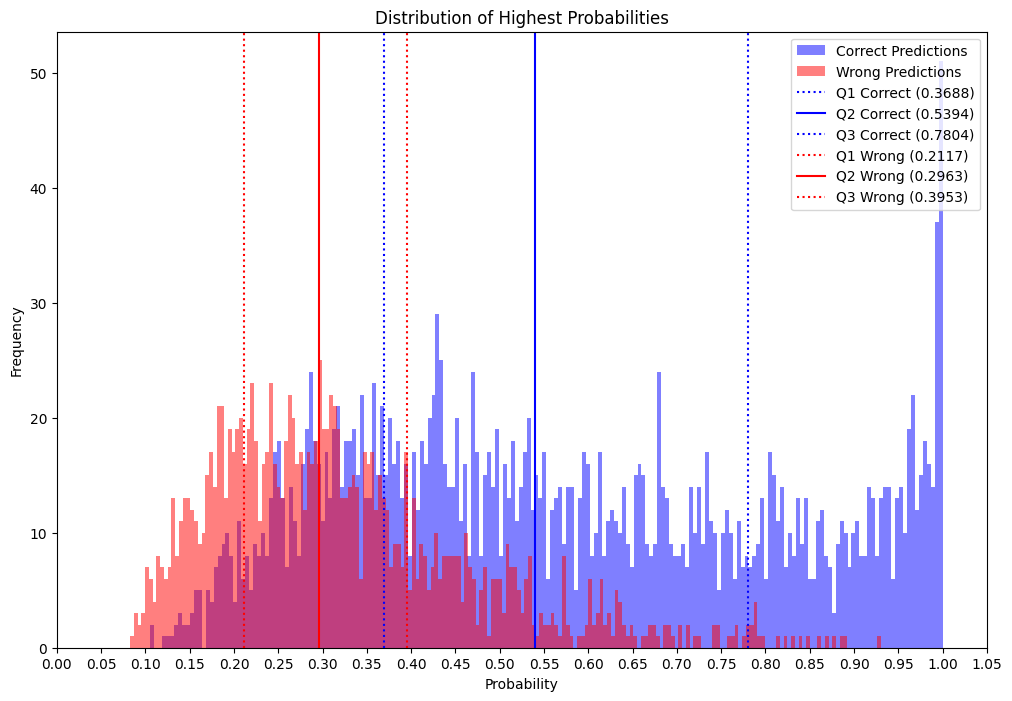

In [19]:
import matplotlib.pyplot as plt

q1_first_proba_c = np.percentile(first_proba_c, 25)
q2_first_proba_c = np.percentile(first_proba_c, 50)
q3_first_proba_c = np.percentile(first_proba_c, 75)

q1_first_proba_w = np.percentile(first_proba_w, 25)
q2_first_proba_w = np.percentile(first_proba_w, 50)
q3_first_proba_w = np.percentile(first_proba_w, 75)

plt.figure(figsize=(12, 8))

plt.hist(first_proba_c, bins=200, alpha=0.5, color='blue', label='Correct Predictions')
plt.hist(first_proba_w, bins=200, alpha=0.5, color='red', label='Wrong Predictions')

plt.axvline(x=q1_first_proba_c, color='blue', linestyle='dotted', label=f'Q1 Correct ({q1_first_proba_c:.4f})')
plt.axvline(x=q2_first_proba_c, color='blue', linestyle='-', label=f'Q2 Correct ({q2_first_proba_c:.4f})')
plt.axvline(x=q3_first_proba_c, color='blue', linestyle='dotted', label=f'Q3 Correct ({q3_first_proba_c:.4f})')

plt.axvline(x=q1_first_proba_w, color='red', linestyle='dotted', label=f'Q1 Wrong ({q1_first_proba_w:.4f})')
plt.axvline(x=q2_first_proba_w, color='red', linestyle='-', label=f'Q2 Wrong ({q2_first_proba_w:.4f})')
plt.axvline(x=q3_first_proba_w, color='red', linestyle='dotted', label=f'Q3 Wrong ({q3_first_proba_w:.4f})')
plt.xlabel('Probability')
plt.ylabel('Frequency')
plt.title('Distribution of Highest Probabilities')
plt.legend()
plt.xticks(np.arange(0, 1.1, 0.05))  # x축 눈금을 0부터 1까지 0.05 단위로 설정
plt.show()

##### **방법 2**: 1위, 2위 라벨에 부여된 확률 차이의 분포 (및 plot을 이용해 시각화)


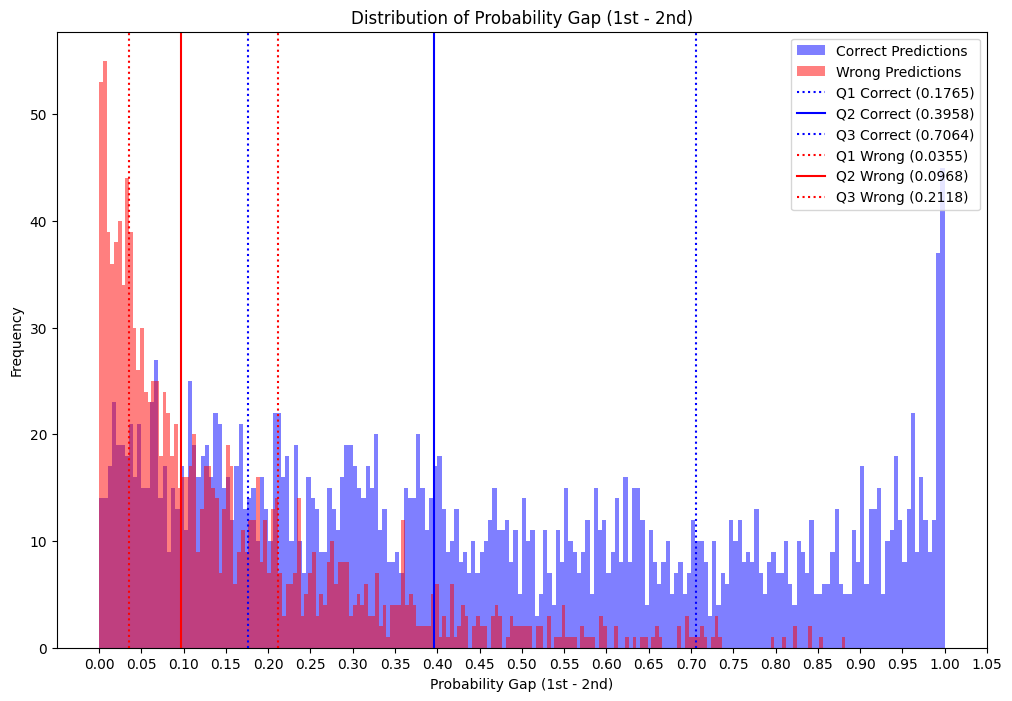

In [20]:
# proba_gap_c와 proba_gap_w의 상위 25%, 50%, 하위 25% 값을 계산
q1_gap_c = np.percentile(proba_gap_c, 25)
q2_gap_c = np.percentile(proba_gap_c, 50)
q3_gap_c = np.percentile(proba_gap_c, 75)
q1_gap_w = np.percentile(proba_gap_w, 25)
q2_gap_w = np.percentile(proba_gap_w, 50)
q3_gap_w = np.percentile(proba_gap_w, 75)

# proba_ratio_w와 proba_ratio_w의 상위 25%, 하위 25% 값을 계산
q1_ratio_c = np.percentile(proba_ratio_c, 25)
q2_ratio_c = np.percentile(proba_ratio_c, 50)
q3_ratio_c = np.percentile(proba_ratio_c, 75)
q1_ratio_w = np.percentile(proba_ratio_w, 25)
q2_ratio_w = np.percentile(proba_ratio_w, 50)
q3_ratio_w = np.percentile(proba_ratio_w, 75)

plt.figure(figsize=(12, 8))

plt.hist(proba_gap_c, bins=200, alpha=0.5, color='blue', label='Correct Predictions')
plt.hist(proba_gap_w, bins=200, alpha=0.5, color='red', label='Wrong Predictions')

plt.axvline(x=q1_gap_c, color='blue', linestyle='dotted', label=f'Q1 Correct ({q1_gap_c:.4f})')
plt.axvline(x=q2_gap_c, color='blue', linestyle='-', label=f'Q2 Correct ({q2_gap_c:.4f})')
plt.axvline(x=q3_gap_c, color='blue', linestyle='dotted', label=f'Q3 Correct ({q3_gap_c:.4f})')

plt.axvline(x=q1_gap_w, color='red', linestyle='dotted', label=f'Q1 Wrong ({q1_gap_w:.4f})')
plt.axvline(x=q2_gap_w, color='red', linestyle='-', label=f'Q2 Wrong ({q2_gap_w:.4f})')
plt.axvline(x=q3_gap_w, color='red', linestyle='dotted', label=f'Q3 Wrong ({q3_gap_w:.4f})')

plt.xlabel('Probability Gap (1st - 2nd)')
plt.ylabel('Frequency')
plt.title('Distribution of Probability Gap (1st - 2nd)')
plt.legend()
plt.xticks(np.arange(0, 1.1, 0.05))  # x축 눈금을 0부터 1까지 0.05 단위로 설정
plt.show()

##### **방법 3**: 1위, 2위 라벨에 부여된 확률의 비율(1st/2nd) 분포 (및 plot을 이용해 시각화)

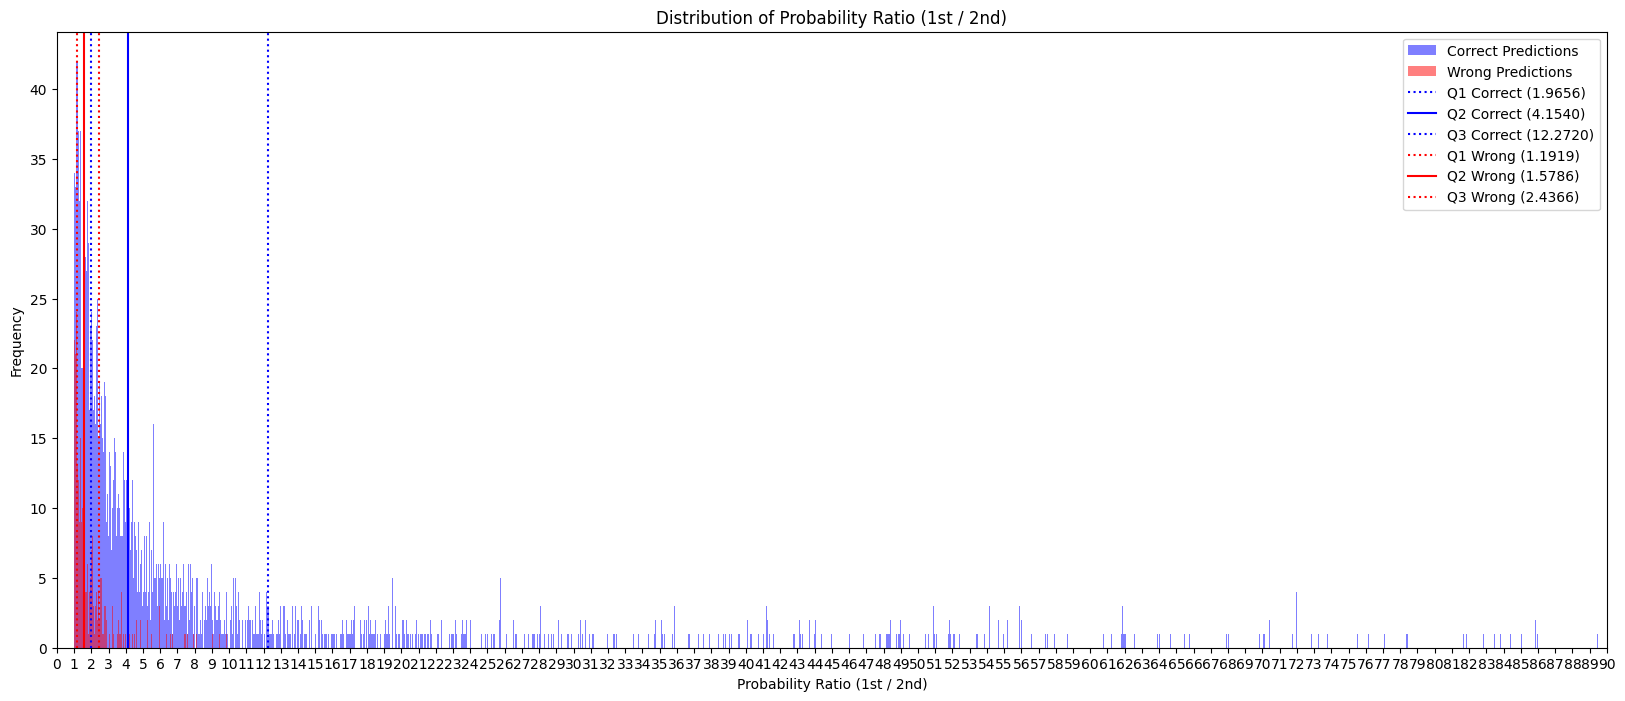

In [21]:
valid_proba_ratio_c = [x for x in proba_ratio_c if x < 99]
plt.figure(figsize=(20, 8))
plt.hist(valid_proba_ratio_c, bins=2000, alpha=0.5, color='blue', label='Correct Predictions')
plt.hist(proba_ratio_w, bins=4000, alpha=0.5, color='red', label='Wrong Predictions')

plt.axvline(x=q1_ratio_c, color='blue', linestyle='dotted', label=f'Q1 Correct ({q1_ratio_c:.4f})')
plt.axvline(x=q2_ratio_c, color='blue', linestyle='-', label=f'Q2 Correct ({q2_ratio_c:.4f})')
plt.axvline(x=q3_ratio_c, color='blue', linestyle='dotted', label=f'Q3 Correct ({q3_ratio_c:.4f})')

plt.axvline(x=q1_ratio_w, color='red', linestyle='dotted', label=f'Q1 Wrong ({q1_ratio_w:.4f})')
plt.axvline(x=q2_ratio_w, color='red', linestyle='-', label=f'Q2 Wrong ({q2_ratio_w:.4f})')
plt.axvline(x=q3_ratio_w, color='red', linestyle='dotted', label=f'Q3 Wrong ({q3_ratio_w:.4f})')

plt.xlabel('Probability Ratio (1st / 2nd)')
plt.ylabel('Frequency')
plt.title('Distribution of Probability Ratio (1st / 2nd)')
plt.legend()
plt.xlim(0, 90) # x축 값 15 이상은 제외함
plt.xticks(np.arange(0, 90.1, 1))  # x축 눈금을 0부터 15까지 0.5 단위로 설정
plt.show()

##### **방법 4**: confidence = f1_class * 1st_proba 🔶 이 방법을 사용하기로 했습니다 - 방법 1~3에 비해 월등히 좋은 것은 아니지만, class별 예측 정확도 차이를 반영할 수 있기 때문

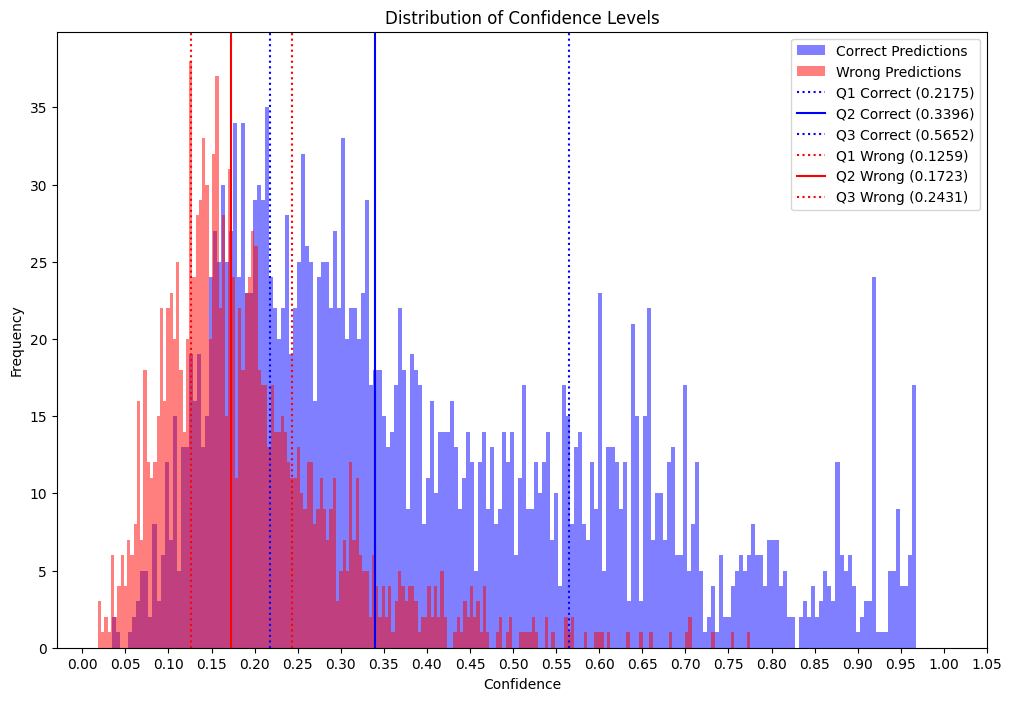

In [22]:
# confidence_c와 confidence_w의 상위 25%, 50%, 하위 25% 값을 계산
q1_confidence_c = np.percentile(confidence_c, 25)
q2_confidence_c = np.percentile(confidence_c, 50)
q3_confidence_c = np.percentile(confidence_c, 75)
q1_confidence_w = np.percentile(confidence_w, 25)
q2_confidence_w = np.percentile(confidence_w, 50)
q3_confidence_w = np.percentile(confidence_w, 75)

plt.figure(figsize=(12, 8))

plt.hist(confidence_c, bins=200, alpha=0.5, color='blue', label='Correct Predictions')
plt.hist(confidence_w, bins=200, alpha=0.5, color='red', label='Wrong Predictions')

plt.axvline(x=q1_confidence_c, color='blue', linestyle='dotted', label=f'Q1 Correct ({q1_confidence_c:.4f})')
plt.axvline(x=q2_confidence_c, color='blue', linestyle='-', label=f'Q2 Correct ({q2_confidence_c:.4f})')
plt.axvline(x=q3_confidence_c, color='blue', linestyle='dotted', label=f'Q3 Correct ({q3_confidence_c:.4f})')

plt.axvline(x=q1_confidence_w, color='red', linestyle='dotted', label=f'Q1 Wrong ({q1_confidence_w:.4f})')
plt.axvline(x=q2_confidence_w, color='red', linestyle='-', label=f'Q2 Wrong ({q2_confidence_w:.4f})')
plt.axvline(x=q3_confidence_w, color='red', linestyle='dotted', label=f'Q3 Wrong ({q3_confidence_w:.4f})')

plt.xlabel('Confidence')
plt.ylabel('Frequency')
plt.title('Distribution of Confidence Levels')
plt.legend()
plt.xticks(np.arange(0, 1.1, 0.05))  # x축 눈금을 0부터 1까지 0.05 단위로 설정
plt.show()


##### **방법 1,2,3,4에 대한 분석** : *best threshold*를 찾고, accuracy, precision, recall, f1-score, confusion matirx 출력
```
<출력 예시>
Best Threshold (confidence criterion): 0.14720727364093775
Best F1-score: 0.8135471086290758
Confusion Matrix:
[[ 507  850]
 [ 185 2258]]
Accuracy: 0.7276
Precision: 0.7265
Recall: 0.9243
```

In [23]:
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score

# 가능한 임계값 생성
p_thresholds = np.unique(proba_top)  # proba_top에서 중복되지 않는 값들을 임계값으로 설정

best_p_f1 = -1
best_p_threshold = None

# 모든 임계값에 대해 F1-score 계산
for p_threshold in p_thresholds:
    predicted_label = (proba_top >= p_threshold).astype(int) # 임계값 이상이면 true
    f1 = f1_score(tf_label, predicted_label)

    # F1-score가 더 높은 경우 업데이트
    if f1 > best_p_f1:
        best_p_f1 = f1
        best_p_threshold = p_threshold

print("Best Threshold (largest probability criterion):", best_p_threshold)
print("Best F1-score:", best_p_f1)

# best_threshold를 기준으로 예측된 레이블 구하기
predicted_labels = (proba_top >= best_p_threshold).astype(int)

conf_matrix = confusion_matrix(tf_label, predicted_labels)

print("Confusion Matrix:")
print(conf_matrix)

# 예측된 레이블과 실제 레이블을 사용하여 accuracy, precision, recall 계산
accuracy = accuracy_score(tf_label, predicted_labels)
precision = precision_score(tf_label, predicted_labels)
recall = recall_score(tf_label, predicted_labels)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

Best Threshold (largest probability criterion): 0.24372771243277355
Best F1-score: 0.814537680384821
Confusion Matrix:
[[ 473  884]
 [ 157 2286]]
Accuracy: 0.7261
Precision: 0.7211
Recall: 0.9357


In [24]:
# 방법 2

# 가능한 임계값 생성
g_thresholds = np.unique(proba_gap)  # proba_gap에서 중복되지 않는 값들을 임계값으로 설정

best_g_f1 = -1
best_g_threshold = None

# 모든 임계값에 대해 F1-score 계산
for g_threshold in g_thresholds:
    predicted_label = (proba_gap >= g_threshold).astype(int) # 임계값 이상이면 true
    f1 = f1_score(tf_label, predicted_label)

    # F1-score가 더 높은 경우 업데이트
    if f1 > best_g_f1:
        best_g_f1 = f1
        best_g_threshold = g_threshold

print("Best Threshold (gap criterion):", best_g_threshold)
print("Best F1-score:", best_g_f1)
from sklearn.metrics import confusion_matrix

# best_threshold를 기준으로 예측된 레이블 구하기
predicted_labels = (proba_gap >= best_g_threshold).astype(int)

conf_matrix = confusion_matrix(tf_label, predicted_labels)

print("Confusion Matrix:")
print(conf_matrix)

# 예측된 레이블과 실제 레이블을 사용하여 accuracy, precision, recall 계산
accuracy = accuracy_score(tf_label, predicted_labels)
precision = precision_score(tf_label, predicted_labels)
recall = recall_score(tf_label, predicted_labels)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

Best Threshold (gap criterion): 0.06129381350383463
Best F1-score: 0.8073228203733913
Confusion Matrix:
[[ 510  847]
 [ 216 2227]]
Accuracy: 0.7203
Precision: 0.7245
Recall: 0.9116


In [25]:
# 방법 3
# 가능한 임계값 생성
r_thresholds = np.unique(proba_ratio)  # proba_ratio에서 중복되지 않는 값들을 임계값으로 설정

best_r_f1 = -1
best_r_threshold = None

# 모든 임계값에 대해 F1-score 계산
for r_threshold in r_thresholds:
    predicted_label = (proba_ratio >= r_threshold).astype(int) # 임계값 이상이면 true
    f1 = f1_score(tf_label, predicted_label)

    # F1-score가 더 높은 경우 업데이트
    if f1 > best_r_f1:
        best_r_f1 = f1
        best_r_threshold = r_threshold

print("Best Threshold (ratio criterion):", best_r_threshold)
print("Best F1-score:", best_r_f1)

# best_threshold를 기준으로 예측된 레이블 구하기
predicted_labels = (proba_ratio >= best_r_threshold).astype(int)

conf_matrix = confusion_matrix(tf_label, predicted_labels)

print("Confusion Matrix:")
print(conf_matrix)

# 예측된 레이블과 실제 레이블을 사용하여 accuracy, precision, recall 계산
accuracy = accuracy_score(tf_label, predicted_labels)
precision = precision_score(tf_label, predicted_labels)
recall = recall_score(tf_label, predicted_labels)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

Best Threshold (ratio criterion): 1.2577874603937818
Best F1-score: 0.8002134851449919
Confusion Matrix:
[[ 428  929]
 [ 194 2249]]
Accuracy: 0.7045
Precision: 0.7077
Recall: 0.9206


In [26]:
# 방법 4
# 가능한 임계값 생성
conf_threshold = np.unique(confidence_all)  # confidence_all 에서 중복되지 않는 값들을 임계값으로 설정
best_confidence_f1 = -1
best_confidence_threshold = None

# 모든 임계값에 대해 F1-score 계산
for confidence_threshold in conf_threshold:
    predicted_label = (confidence_all >= confidence_threshold).astype(int) # 임계값 이상이면 true
    f1 = f1_score(tf_label, predicted_label)

    # F1-score가 더 높은 경우 업데이트
    if f1 > best_confidence_f1:
        best_confidence_f1 = f1
        best_confidence_threshold = confidence_threshold

print("Best Threshold (confidence criterion):", best_confidence_threshold)
print("Best F1-score:", best_confidence_f1)

# best_threshold를 기준으로 예측된 레이블 구하기
predicted_labels = (confidence_all >= best_confidence_threshold).astype(int)

conf_matrix = confusion_matrix(tf_label, predicted_labels)

print("Confusion Matrix:")
print(conf_matrix)

# 예측된 레이블과 실제 레이블을 사용하여 accuracy, precision, recall 계산
accuracy = accuracy_score(tf_label, predicted_labels)
precision = precision_score(tf_label, predicted_labels)
recall = recall_score(tf_label, predicted_labels)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

Best Threshold (confidence criterion): 0.14720727364093775
Best F1-score: 0.8135471086290758
Confusion Matrix:
[[ 507  850]
 [ 185 2258]]
Accuracy: 0.7276
Precision: 0.7265
Recall: 0.9243


# **5. 방법 4를 이용한 monitored data분류**
# -1로 예측한 비율이 적어야 좋고 (모두 monitored data이므로), -1로 예측한 것들 중 틀리게 예측한 비율이 높아야 좋다(어차피 0~94를 내놓아도 틀리므로)

In [ ]:
probability = clf.predict_proba(X_test)
sorted_index = np.argsort(probability, axis=1)
data_list = []

for i, (sorted_index, pred_class) in enumerate(zip(sorted_index, y_pred)):
    print(f"Test Data {i}, Predicted Class {pred_class}")
    for j, index in enumerate(sorted_index[::-1][:1]):
        f1 = f1_class[pred_class]
        pred_proba = probability[i][index]
        confidence = pred_proba * f1
        print(f"Predicted Class {index}: {probability[i][index]}") # 확률 상위 1개 class만 출력
        print(f"Class {index}의 f1-score: {f1}")
        print(f"Confidence: {confidence}")
        if(confidence >= best_confidence_threshold) : #
          data_list.append([i, pred_class, pred_proba, f1, confidence, tf_label[i]])
        else : #confidence 가 낮으면 -1로 분류하자
          data_list.append([i, -1, pred_proba, f1, confidence, tf_label[i]])
    print()

columns = ['Test Data Index', 'Predicted Class', 'Probability', 'f1-score of predicted class','Confidence','tf_label']
result = pd.DataFrame(data_list, columns=columns)

In [ ]:
result

In [ ]:
# 전체 데이터 수
total_samples = len(result)

# 'Predicted Class'가 -1인 개수 계산
count_minus1 = len(result[result['Predicted Class'] == -1])
print(f'전체 {total_samples}개 중에서 Predicted Class가 -1인 데이터의 개수: {count_minus1}')

# 'Predicted Class'가 -1이고 wrong prediction인 개수 계산 - 어차피 wrong prediction이므로 "-1" 로 분류되어도 괜찮음
count_minus1_and_label_0 = len(result[(result['Predicted Class'] == -1) & (result['tf_label'] == 0)])
print(f'Predicted Class가 -1이고 tf_label이 0인 데이터의 개수: {count_minus1_and_label_0}')

# 'Predicted Class'가 -1이고 correct prediction인 개수 계산
count_minus1_and_label_1 = len(result[(result['Predicted Class'] == -1) & (result['tf_label'] == 1)])
print(f'Predicted Class가 -1이고 tf_label이 1인 데이터의 개수: {count_minus1_and_label_1}')

print()
# 'Predicted Class'가 0~94인 개수 계산
count_class_monitored = len(result[result['Predicted Class'] != -1])
print(f'전체 {total_samples}개 중에서 Predicted Class가 0~94인 데이터의 개수: {count_class_monitored}')

# Predicted Class 가 0~94인 데이터 중 correct prediction(tflabel=0)인 개수 - 잘못 분류된 것들
count_monitored_and_label_0 = len(result[(result['Predicted Class'] != -1) & (result['tf_label'] == 0)])
print(f'Predicted Class가 0~94 이고 tf_label이 0인 데이터의 개수: {count_monitored_and_label_0}')

# Predicted Class 가 0~94인 데이터 중 correct prediction(tflabel=1)인 개수 - 성공적으로 분류된 것들
count_monitored_and_label_1 = len(result[(result['Predicted Class'] != -1) & (result['tf_label'] == 1)])
print(f'Predicted Class가 0~94 이고 tf_label이 1인 데이터의 개수: {count_monitored_and_label_1}')


In [ ]:
# 데이터 준비
categories = ['Monitored & Correct Prediction', 'Monitored & Wrong Prediction', 'Unmonitored & Correct Prediction', 'Unmonitored & Wrong Prediction']
values = [count_monitored_and_label_1, count_monitored_and_label_0, count_minus1_and_label_1, count_minus1_and_label_0]

# 그래프 그리기
plt.figure(figsize=(16, 6))

plt.bar(categories, values, color=['blue', 'red', 'green', 'orange'])

plt.xlabel('Categories')
plt.ylabel('Counts')
plt.title('Counts Comparison')

plt.show()

# **6. Classification of Unmonitored Data**
#### **---> 일단 0~94 분류를 하고, confidence < best_confidence_threshold이면 그 label을 -1로 변경**
*TO-DO
1. Binary Classification : mark the data as monitored(Y) or NOT(N) - **need to establish criteria for labeling monitored or not**
2. Multi-Class Classification: Re classify samples that were labeled as 'Y' - mark label 0 to 94

## 1. Load Data

In [ ]:
import pickle
from google.colab import drive
drive.mount('/content/gdrive')

TOTAL_URLS = 10000  # total number in the dataset

# Load 10,000 unmon pickle file
print("Loading datafile...")
with open('/content/gdrive/My Drive/Colab Notebooks/unmon_standard10.pkl', 'rb') as f:  # Path to unmon_standard10.pkl in Colab
    x = pickle.load(f)

size = len(x)
print(f'Total samples: {size}')

X1 = [] # Array to store instances (timestamps) - 10,000 instances, e.g., [[0.0, 0.5, 3.4, ...], [0.0, 4.5, ...], [0.0, 1.5, ...], ... [... ,45.8]]
X2 = [] # Array to store instances (direction*size) - size information

for i in range(TOTAL_URLS):
    size_seq = []
    time_seq = []
    for c in x[i]:
        dr = 1 if c > 0 else -1
        time_seq.append(abs(c))
        size_seq.append(dr * 512) # In the pickle file, there is no size information, so the conversion code is set to multiply by 512 uniformly.
    X1.append(time_seq)
    X2.append(size_seq)

print(len(X1)) # Print the length of X1

## 2. Make Dataframe

In [ ]:
n_pack = [] #Array to store total number of packets
n_in = [] #Array to store number of incoming packets : server -> client (size < 0)
n_out = [] #Array to store number of outgoing packets : client -> server (size > 0)
r_in = [] #Array to store ratio of incoming packets
r_out = [] #Array to store ratio of outcoming packets
in_first = [] #Array to store number of incoming packet in First 30 Packets
out_first = [] #Array to store number of outcoming packet in First 30 Packets
transmission_time = [] #Array to store total transmission time
packets_per_sec = [] #Array to store #of packets per second

for i in range (0,len(X2)):
  count = 0
  count_30 = 0
  for j in range (0,len(X2[i])):
    if X2[i][j] < 0:
      count+=1
      if j < 30: #incoming packet이고 처음 30개 안에 해당된다면
        count_30+=1
  n_pack.append(len(X2[i]))
  n_in.append(count)
  n_out.append(len(X2[i])-count)
  r_in.append(count/len(X2[i]))
  r_out.append(1-count/len(X2[i]))
  in_first.append(count_30)
  out_first.append(30-count_30)
  transmission_time.append(X1[i][-1])
  packets_per_sec.append(len(X2[i])/X1[i][-1])

In [ ]:
####### df_unmon
df_unmon = pd.DataFrame({"total packets": n_pack, "#of incoming packets": n_in, "#of outgoing packets": n_out,
                       "ratio of incoming packets": r_in, "ratio of outgoing packets": r_out,
                       "#of incoming(first30)": in_first, "#of outgoing(first30)": out_first, "total time": transmission_time, "#of packets per sec": packets_per_sec, "label": None})